In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sklearn import metrics

## Data Cleaning

In [2]:
closed =pd.read_csv("https://final-project-data-uci-da-bootcamp.s3-us-west-2.amazonaws.com/California_Real_Estate_Raw_Data_Set.csv")
city_names = pd.read_csv("https://final-project-data-uci-da-bootcamp.s3-us-west-2.amazonaws.com/city_code_to_city.csv")


In [3]:
closed_df = pd.DataFrame(closed)
city_name_df = pd.DataFrame(city_names)

In [4]:
closed_df.drop(columns = ["Unnamed: 0"], inplace = True)

In [5]:
closed_df.drop(columns = ["MLS Area","MLS Area","MLS","BAC","DOM/CDOM","SLC","S","Sub Type"], inplace = True)

In [6]:
closed_df = closed_df.dropna()

In [7]:
closed_df.rename(columns = {"County ": "County"}, inplace = True)

In [8]:
closed_df.rename(columns = {"Contract Status Change Date": "Date"}, inplace = True)

In [9]:
closed_df.Date = pd.to_datetime(closed_df.Date, format = "%m/%d/%y")

In [10]:
closed_df[['Price Per Square Foot']] = closed_df[['Price Per Square Foot']].replace('[\$,]','',regex=True).astype(float)


In [11]:
closed_df[['L/C Price']] = closed_df[['L/C Price']].replace('[\$,]','',regex=True).astype(float)

In [12]:
closed_df[["Sqft"]] = closed_df.Sqft.str.split('/', expand=True).drop([1], axis = 1)

In [13]:
closed_df[["YrBuilt"]] = closed_df.YrBuilt.str.split('/', expand=True).drop([1], axis = 1)

In [14]:
closed_df[["Bed & Bath", "A", "Attic", "Basement"]] = closed_df['Br/Ba'].str.split(",", expand = True)


In [15]:
closed_df[["Bed", "Bath"]] = closed_df["Bed & Bath"].str.split("/", expand = True)

In [16]:
closed_df.drop(columns = ["A"],inplace = True)

In [17]:
closed_df.columns

Index(['Listing ID', 'St#', 'St Name', 'City', 'L/C Price',
       'Price Per Square Foot', 'Br/Ba', 'Sqft', 'YrBuilt', 'LSqft/Ac',
       'View YN', 'Pool Private YN', 'Date', 'County', 'Bed & Bath', 'Attic',
       'Basement', 'Bed', 'Bath'],
      dtype='object')

In [18]:
closed_df.drop(columns = "Bed & Bath", inplace = True)

In [19]:
closed_df.rename(columns = {"Sqft": "Sqft/A"}, inplace = True)
closed_df[["LSqft", "Ac"]] = closed_df['LSqft/Ac'].str.split('/', expand = True).replace('[\$,]','',regex=True).astype(float)

In [20]:
closed_df.drop(columns = ["St#","St Name","LSqft/Ac","Ac","Date"], inplace = True)

In [21]:
len(closed_df.columns)

15

In [22]:
closed_df.rename(columns = {"Price Per Square Foot":"Price_Per_Square_Foot", "Pool Private YN":"Private_Pool","View YN":"View"}, inplace = True)

In [23]:
clean_df = closed_df

In [24]:
clean_df.replace({"Y":1,"N":0},inplace = True)

In [25]:
clean_df.drop(columns = ["Br/Ba"], inplace = True)

In [26]:
clean_df.YrBuilt = clean_df.YrBuilt.astype(int)

In [27]:
clean_df.Attic = clean_df.Attic.astype(int)

In [28]:
clean_df.Basement = clean_df.Basement.astype(int)

In [29]:
clean_df.Bed = clean_df.Bed.astype(int)
clean_df.Bath = clean_df.Bath.astype(int)

In [30]:
clean_df.drop(columns = ["Listing ID"], inplace = True)

In [31]:
clean_df.columns

Index(['City', 'L/C Price', 'Price_Per_Square_Foot', 'Sqft/A', 'YrBuilt',
       'View', 'Private_Pool', 'County', 'Attic', 'Basement', 'Bed', 'Bath',
       'LSqft'],
      dtype='object')

In [32]:
[clean_df.County == "Riverside"] or [clean_df.County ==  "Los Angeles"] or [clean-df.County == "Orange"]

[0        False
 1        False
 2        False
 3        False
 4        False
          ...  
 22104    False
 22105    False
 22106    False
 22107    False
 22108    False
 Name: County, Length: 22045, dtype: bool]

In [33]:
clean_df = clean_df.merge(city_name_df, left_on = "City", right_on = "City_ID", how = "left" )

In [34]:
clean_df = clean_df.dropna()

In [35]:
clean_df.drop(columns = ["City_x", "City_ID"],inplace = True)

In [36]:
clean_df.columns

Index(['L/C Price', 'Price_Per_Square_Foot', 'Sqft/A', 'YrBuilt', 'View',
       'Private_Pool', 'County', 'Attic', 'Basement', 'Bed', 'Bath', 'LSqft',
       'City_y'],
      dtype='object')

In [37]:
clean_df.rename(columns = {"City_y":"City"}, inplace = True)

In [38]:
clean_df

,L/C Price,Price_Per_Square_Foot,Sqft/A,YrBuilt,View,Private_Pool,County,Attic,Basement,Bed,Bath,LSqft,City
0,1070000.0,568.54,1882,1960,1,0,Orange,0,0,3,2,2938.0,Seal Beach
1,1299000.0,556.08,2336,1958,1,0,Orange,0,0,4,2,5880.0,Seal Beach
2,590000.0,490.03,1204,1957,1,0,Orange,0,0,3,2,6237.0,Stanton
3,679000.0,523.92,1296,1964,1,0,Orange,0,0,3,2,1584.0,Huntington Beach
4,715000.0,607.99,1176,1964,1,1,Orange,0,0,3,2,6675.0,Huntington Beach
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19565,549999.0,254.63,2160,1958,1,0,San Bernardino,0,0,5,2,9720.0,Redlands
19566,699000.0,406.40,1720,1940,1,0,San Bernardino,0,0,3,2,6950.0,Redlands
19572,330000.0,228.22,1446,1959,1,0,San Bernardino,0,0,3,2,10260.0,Colton
19617,260000.0,202.33,1285,1955,1,0,San Bernardino,0,0,3,2,7504.0,Redlands


In [39]:
riverside = clean_df[clean_df.County == "Riverside"]
los_angeles = clean_df[clean_df.County == "Los Angeles"]
orange = clean_df[clean_df.County == "Orange"]


In [40]:
CA = riverside.append(los_angeles)

In [41]:
ca_df = CA.append(orange)

In [42]:
ca_df.reset_index()
len(ca_df)

12166

In [43]:
county_rank = ca_df.loc[:,["L/C Price", "County"]]

In [44]:
county_rank = county_rank.groupby("County").mean()

In [45]:
county_rank.sort_values(by = "L/C Price")

,L/C Price
County,
Riverside,433577.542398
Los Angeles,667185.581683
Orange,838591.011329


In [46]:
ca_df.replace({"Riverside":1, "Los Angeles":2, "Orange":3}, inplace = True)

In [47]:
ca_df.Attic.unique()

array([1, 0, 2])

In [48]:
# ca_df.drop(columns = "Price_Per_Square_Foot", inplace = True)

In [49]:
len(ca_df.City.unique())

236

In [50]:
ca_df = ca_df.loc[:,['L/C Price',"City", 'Price_Per_Square_Foot', 'Sqft/A', 'YrBuilt',
       'View', 'Private_Pool', 'County', 'Attic', 'Basement', 'Bed', 'Bath',
       'LSqft']]

In [51]:
city_ranking = ca_df.loc[:,["City","L/C Price"]]

In [52]:
city_ranking = city_ranking.groupby("City").mean()

In [53]:
city_ranking = city_ranking.sort_values(by='L/C Price', ascending=True).reset_index()

In [54]:
city_ranking["city_rank"] = city_ranking.index + 1

In [55]:
len(ca_df)

12166

In [56]:
ca_df = ca_df.merge(city_ranking, left_on = 'City', right_on=  'City', how = "left")

In [57]:
Riverside_Cities = clean_df[clean_df.County == "Riverside"]
Los_Angeles_Cities = clean_df[clean_df.County == "Los Angeles"]
Orange_Cities = clean_df[clean_df.County == "Orange"]

In [58]:
ca_df.drop(columns = ["City","L/C Price_y"], inplace = True)
ca_df.rename(columns = {"L/C Price_x":"L/C Price"}, inplace = True)

In [59]:
ca_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12166 entries, 0 to 12165
Data columns (total 13 columns):
L/C Price                12166 non-null float64
Price_Per_Square_Foot    12166 non-null float64
Sqft/A                   12166 non-null object
YrBuilt                  12166 non-null int64
View                     12166 non-null int64
Private_Pool             12166 non-null int64
County                   12166 non-null int64
Attic                    12166 non-null int64
Basement                 12166 non-null int64
Bed                      12166 non-null int64
Bath                     12166 non-null int64
LSqft                    12166 non-null float64
city_rank                12166 non-null int64
dtypes: float64(3), int64(9), object(1)
memory usage: 1.3+ MB


## Starting the model

In [60]:
ca_model = ca_df.reset_index()

In [61]:
ca_model.drop(columns = 'index', inplace = True)

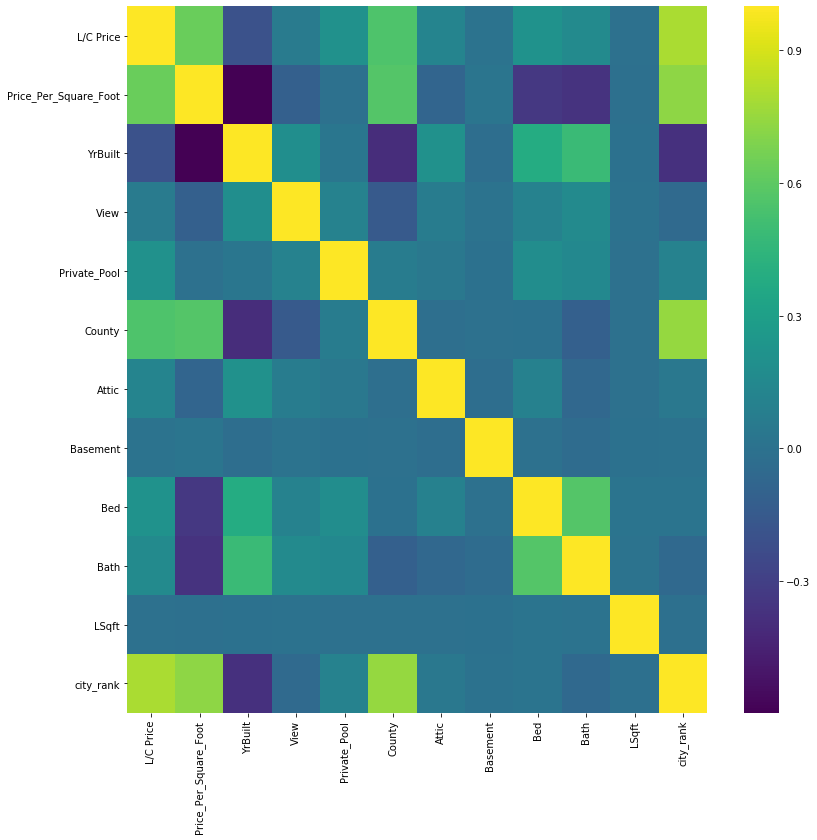

In [62]:
ca_model
fig = plt.figure(figsize = (13,13))
sns.heatmap(ca_model.corr(), annot = False, vmax = 1, cmap = 'viridis', square = False)

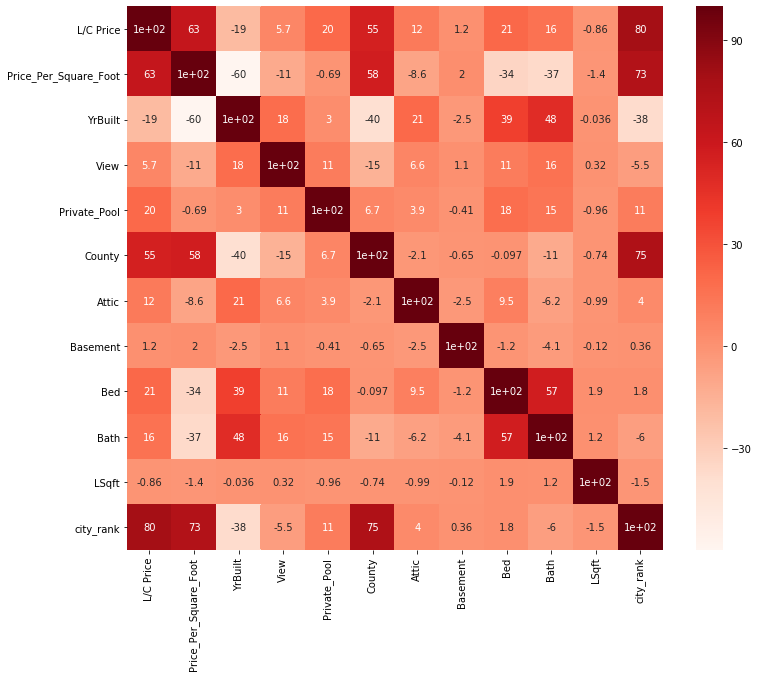

In [63]:
plt.figure(figsize = (12,10))
cor = ca_model.corr()*100
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

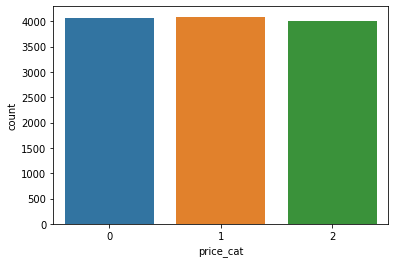

In [64]:
ca_classification = ca_model.assign(
    price_cat = pd.qcut(
        ca_model['L/C Price'],
        q=3,
        duplicates='drop',
        labels=[0,1,2]
    )
)

# Visualize the Split
sns.countplot(ca_classification['price_cat'])

In [65]:
ca_classification.columns

Index(['L/C Price', 'Price_Per_Square_Foot', 'Sqft/A', 'YrBuilt', 'View',
       'Private_Pool', 'County', 'Attic', 'Basement', 'Bed', 'Bath', 'LSqft',
       'city_rank', 'price_cat'],
      dtype='object')

In [66]:
y = ca_classification['L/C Price']
X =ca_classification[["Price_Per_Square_Foot","city_rank", 'YrBuilt', 'View',
       'Private_Pool', 'County', 'Attic', 'Basement', 'Bed', 'Bath', 'LSqft']]

In [67]:
X.head(1)

,Price_Per_Square_Foot,city_rank,YrBuilt,View,Private_Pool,County,Attic,Basement,Bed,Bath,LSqft
0,257.57,17,1922,1,0,1,1,0,1,1,6970.0


In [68]:
y.head(1)

0    234900.0
Name: L/C Price, dtype: float64

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
X_test.shape

(2434, 11)

In [71]:
X_train.shape

(9732, 11)

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


In [73]:
# rf = RandomForestClassifier(n_estimators=200)

In [74]:
#  rf = rf.fit(X_train, y_train)

In [75]:
# rf.score(X_test, y_test) 

In [76]:
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_train, y_train)
# clf.predict(X_test)

In [77]:
# clf.score(X_test,y_test) 

In [78]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
print(f"Training Data Score: {regressor.score(X_train, y_train)}")
print(f"Testing Data Score: {regressor.score(X_test, y_test)}")

Training Data Score: 0.7738537672984285
Testing Data Score: 0.783726082023964


In [79]:
y_pred = regressor.predict(X_test)
y_pred

array([315015.35791759, 290877.46993502, 622038.04872975, ...,
       404799.75894444, 725023.85204242, 777085.94845354])

In [80]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df
df1 = df

In [81]:
# df1

In [82]:
 from sklearn.metrics import mean_squared_error

In [83]:
pattern = "%.0f"
y_pred = [pattern % int(i) for i in y_pred]
y_pred = [int(i) for i in y_pred]
mean_squared_error(y_test, y_pred)

16190489471.254725

In [84]:
from sklearn.metrics import r2_score
print('R2 Score: ', r2_score(y_test,y_pred))

R2 Score:  0.7837261613071291


In [85]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 92689.79950698439
Mean Squared Error: 16190489471.254725
Root Mean Squared Error: 127241.8542432274


## Saving the model to load into Flask

In [86]:
import pickle

In [87]:
# Saving model to disk
pickle.dump(regressor, open('ca_model.pkl','wb'))

In [88]:
# 257.57	19	1922	1	0	1	1	0	1	1	6970.0

In [89]:
# Loading model to compare the results
ca_model = pickle.load(open('ca_model.pkl','rb'))
print(ca_model.predict([[257.57,19,1922,1,0,1,1,0,1,1,6970.0]]))

[161836.47637337]
